In [4]:
from gekko import brain
import struct
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [5]:
# Get data from binary file

In [6]:
file = open("D:/Documents/RLUtilities/assets/soccar/soccar_navigation_nodes.bin",
            "rb")
xd = []
yd = []
zd = []
byte = file.read(4)
while(byte):
    xd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    yd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    zd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)

In [7]:
file = open("D:/Documents/RLUtilities/assets/soccar/soccar_navigation_normals.bin",
            "rb")
xnd = []
ynd = []
znd = []
byte = file.read(4)
while(byte):
    xnd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    ynd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    znd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)

In [8]:
len(xd), len(yd), len(zd), len(xnd), len(ynd), len(znd)

(12115, 12115, 12115, 12115, 12115, 12115)

In [9]:
# setup input and output matricies
# dim(axis) 0 is input layer size (3), and dim(axis) 1 is #datasets
# Transpose since vector comes in with axis 0 the data sets
x = np.asarray(xd).T
y = np.asarray(yd).T
z = np.asarray(zd).T
xn = np.asarray(xnd).T
yn = np.asarray(ynd).T
zn = np.asarray(znd).T
x.shape, y.shape, z.shape, xn.shape, yn.shape, zn.shape

((1, 12115), (1, 12115), (1, 12115), (1, 12115), (1, 12115), (1, 12115))

In [10]:
input = np.concatenate((x,y,z), axis = 0)
output = np.concatenate((xn, yn, zn), axis = 0)
input.shape, output.shape

((3, 12115), (3, 12115))

In [11]:
# Remove x y z < 0
i = input[:, np.all(input > 0, axis=0)]
o = output[:, np.all(input >0, axis=0)]
np.all(i>0), i.shape, o.shape

(True, (3, 2967), (3, 2967))

In [12]:
# Shuffle array so that the first 1000 give hopefully good cover on the manifold
def shuffle(node, norm):
    n = len(node[0])
    grid = np.zeros(n, dtype=np.int32)
    for i in range(0,len(grid)): grid[i] = i
    np.random.shuffle(grid)
    print('grid: ', grid)
    return node[:,grid], norm[:,grid]
i,o = shuffle(i, o)
print('i: ', i, ' | o: ', o)

grid:  [1100 1568 1081 ...  143 2341   18]
i:  [[2560.  128. 1920. ... 1664. 3200.  384.]
 [3200. 5103. 5103. ... 1024. 1792.  640.]
 [  17.  896.  384. ...   17. 2031.   17.]]  | o:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0. -1. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1. -1.  1.]]


In [13]:
start = 0
stop = 500
ip1=i[:,start:stop]
op1 = o[:,start:stop]
ip1.shape, op1.shape

((3, 500), (3, 500))

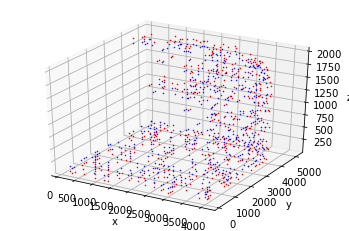

In [14]:
#Initialize 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, ip1[0], ip1[1], ip1[2], 'r*', markersize=1)
Axes3D.plot(ax, ip1[0] + op1[0]*100, ip1[1] + op1[1]*100, ip1[2] + op1[2]*100, 'b.', markersize=1)


In [15]:
b = brain.Brain(m=[], remote = False, bfgs=True, explicit = False)

In [16]:
b.input_layer(3)
b.layer(linear=6)
b.layer(tanh=6)
b.layer(linear=6)
b.output_layer(3)

In [17]:
# b.input_layer(3)
# b.layer(ltype = 'dense', linear=6)
# b.layer(ltype = 'dense', tanh=10)
# b.layer(ltype = 'dense', linear=6)
# b.output_layer(3, ltype='dense', activation='linear')

In [18]:
# save brain
pickle.dumps(b, open("field_brain.p", "wb"))

TypeError: an integer is required (got type _io.BufferedWriter)

In [15]:
b.shake(1)

In [16]:
i[:, :10].shape, o[:,:10].shape

((3, 10), (3, 10))

In [17]:
b.learn(i[:,:500], o[:,:500], obj=2, gap=0.001, disp=True)

 ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  177
   Intermediates:  0
   Connections  :  0
   Equations    :  45
   Residuals    :  45
 
 Number of state variables:    22629
 Number of total equations: -  22500
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    129
 
 **********************************************
 Model Parameter Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public Licen

In [18]:
depth = 2500
op = np.asarray(b.think(i[:, 0:depth]))


In [2]:
#Get a crude mean and variance from training data to output
ip = i[:, 0:depth]
oc = o[:, 0:depth]
diff = op - oc
np.var(diff, axis=1), np.mean(diff, axis=1)

NameError: name 'i' is not defined

In [1]:
#Initialize 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, ip[0], ip[1], ip[2], 'g*', markersize=3)
Axes3D.plot(ax, ip[0] + oc[0]*100, ip[1] + oc[1]*100, ip[2] + oc[2]*100, 'r.', markersize=3)
Axes3D.plot(ax, ip[0] + op[0]*100, ip[1] + op[1]*100, ip[2] + op[2]*100, 'b.', markersize=3)
# Axes3D.plot(ax, diff[0], diff[1], diff[2])

NameError: name 'plt' is not defined

In [21]:
xt = np.expand_dims(np.linspace(-3000, -3100, 11), axis=1).T
yt = np.expand_dims(np.linspace(-4600, -4500, 11), axis=1).T
zt = np.expand_dims(np.ones(xt[0].shape)*17, axis=1).T
ii = np.concatenate((zt,yt,zt), axis = 0)
oe = np.asarray(b.think(ii))
oe.shape

(3, 11)

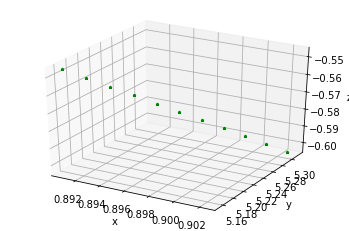

In [22]:
#Initialize 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, op[0], op[1], op[2], 'g*', markersize=3)
# Axes3D.plot(ax, ip[0] + oc[0]*100, ip[1] + oc[1]*100, ip[2] + oc[2]*100, 'r.', markersize=3)
# Axes3D.plot(ax, ip[0] + op[0]*100, ip[1] + op[1]*100, ip[2] + op[2]*100, 'b.', markersize=3)

In [23]:
mask = x>-3000
xt = x[mask]
yt = y[mask]
zt = z[mask]
mask2 = inrange<-2900
xt = xt[mask2]
yt = yt[mask2]
zt = zt[mask2]
xt, yt, zt

NameError: name 'inrange' is not defined